In [1]:
import scipy.stats as stats
import numpy
import matplotlib.pyplot as pyplot
from collections import Counter, defaultdict

from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_ind, sem, beta, laplace, ttest_1samp
)
from statsmodels.stats.proportion import proportion_confint
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn
from tqdm.notebook import tqdm

import sys
sys.path.append('.')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert):
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'

    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

In [16]:
s1 = stats.gamma(a=1.75, scale=2).rvs(1000)
# s2 = stats.gamma(a=1.75, scale=2).rvs(1000)


numpy.quantile(s1, 0.75)

np.float64(4.533086595762159)

In [20]:
numpy.save('bootstrap_example_1.npy', s1)

# Лекция X. Bootstrap

На этой лекции мы рассмотрим один из главных методов статистики, который позволит вам построить критерий для любой сколь угодно сложной гипотезы, которая может у вас возникнуть на практике.

Давайте рассмотрим следующую задачу:

> 📈 **Задача**
>
> Вы работаете аналитиком в такси. Недавно один из менеджеров компании пришел к нам с идеей, что у нас в приложении часто выбирается водитель, который очень далеко от пользователя. И это приводит к оттоку пользователей нашего сервиса.
>
> Для того, чтобы в будущем оценить, насколько вы улучшили алгоритм подбора водителей, вы решаете использовать 75 процентиль распределения времени ожидания такси как основную метрику качества алгоритма. Ваша задача сейчас оценить текущее значение метрики, чтобы в будущем использовать это значение как бейзлайн.

Запишем задачу на языке математики:

- Пусть $X$ &mdash; выборка метрики времени ожидания такси пользователем, $X_{[0.75]}$ &mdash; 75 процентиль этой выборки.

А теперь посмотрим на данные:

In [21]:
sample = numpy.load('bootstrap_example_1.npy')

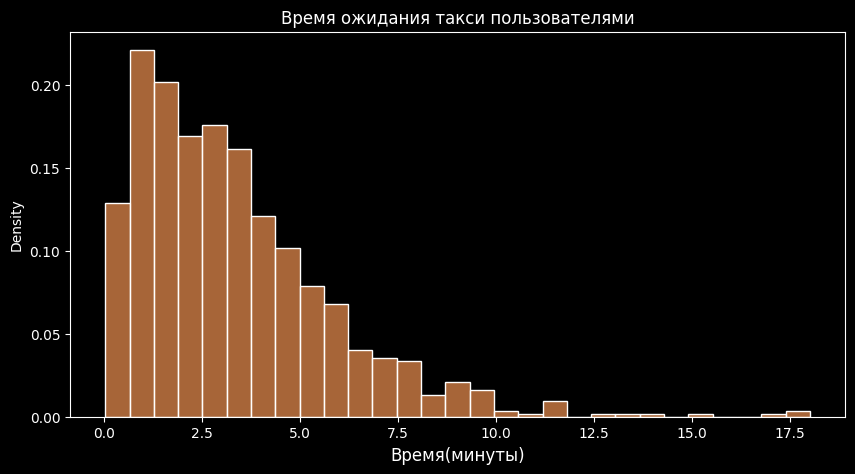

In [22]:
pyplot.figure(figsize=(10, 5))
pyplot.title('Время ожидания такси пользователями', fontsize=12)
seaborn.histplot(sample, stat='density')
pyplot.xlabel('Время(минуты)', fontsize=12)
pyplot.show()

In [23]:
print(f"Оценка 75 процентили: {round(numpy.percentile(sample, 75), 3)}")

Оценка 75 процентили: 4.533


Мы получили некоторую точечную оценку. Но точечная оценка не до конца оценивает некую характеристику в генеральной совокупности. **Нужно построить для нее доверительный интервал.**

Но пока мы не знаем как это сделать.
  
Привычный Т-тест, которым мы оцениваем среднее, не подходит, так как им мы оцениваем среднее, а у нас тут процентиль.  
  
Забегая вперед: **бутстрап хорош не только для процентилей. Он хорош для произвольных характеристик генеральной совокупности, которые мы можем получить по выборке**

----

### Идея 1: Монте-Карло

Для того, чтобы решить задачу, перейдем к более простой выборке, у которой мы уже все знаем: и распределение, из которого она сгенерирована, и истинный квантиль. И на ее примере попытаемся решить задачу.

In [24]:
numpy.random.seed(42)
N = 20000
example_dist = stats.gamma(a=2, scale=3) # истинное распределение
example_sample = example_dist.rvs(N)     # выборка

- Пусть $\theta$ &mdash; истинное значение квантили, которое мы не знаем. В общем случае это может быть любая характеристика: мат. ожидание, дисперсия и т.д.
- $\widehat{\theta}$ &mdash; полученная оценка $\theta$ по выборке. В изначальной задаче ее реализация равна 4.596.

Давайте посмотрим, чему они равны в нашем искусственном примере.

In [25]:
theta = example_dist.ppf(0.75)
theta_estim = numpy.percentile(example_sample, 75)

print(f"theta = {round(theta, 3)}")
print(f"theta estim = {round(theta_estim, 3)}")

theta = 8.078
theta estim = 8.106


Как посторить доверительный интервал для $\theta$?

1. Для этого предлагаю первым шагом построить распределение $\Delta = \widehat{\theta} - \theta$.
    - Смысл &mdash; понять, насколько может шуметь оценка относительно истинного значения. Далее, с помощью этого распределения мы и построим дов. интервал.
    - Пока мы будем исходить, что мы знаем $\theta$ и истинное распределение. Но далее мы сможем избавиться от этого.

Построим это распределение для нашей искусственной задачи. Давайте воспользуемся любимым методом: Монте-Карло.

Мы построим выборку $\Delta_1,\ \dots,\ \Delta_B $. Для этого:

- Насемплируем `B` раз из нашего распределения `example_dist` выборку.
    - `B` возьмем достаточно большим: например, 10000.
    - Размер каждой выборки равен N, изначальному размеру выборки. Ведь мы хотим оценить $\widehat{\theta} - \theta$, где $\widehat{\theta}$построена по выборке размера N. Если взять слишком большую выборку (размера бесконечность), то у вас не будет шума и $\Delta = 0$, хотя для выборки размера $N$ шум будет.
- Посчитаем в каждом случае $\widehat{\theta_i}$.
- А дальше вычтем из этого значения $\theta$. Получим `B` значений $\Delta_i = \widehat{\theta_i} - \theta$.

Напишем функцию генерации выборки $\widehat{\theta_i}$. Эта функция будет основой нашего будущего алгоритма.

In [27]:
def get_estim_theta_sample(sample_len, gen_sample_func, theta_func, B=10000):
    """
        Функция для генерации выборки theta estim.

        Праметры:
            - sample_len: какого размера выборку надо генерировать.
                - sample_len = len(sample)
            - gen_sample_func: генерация выборки из нашего распределения, принимающая на вход лишь размер выборки.
                - Например, gen_sample_func = lambda N: stats.norm().rvs(N)
            - theta_func: функция генерации оценки theta по выборке.
                - Например, lambda sample: numpy.percentile(sample, 75)
            - B: сколько выборок надо сгенерировать, какого размера будет массив theta estim
        Возвращает:
            - Массив theta_estim_array размера B
    """

    theta_estim_array = []
    for _ in range(B):
        curr_sample = gen_sample_func(sample_len) # генерирует выборку
        theta_estim = theta_func(curr_sample)     # оценивает по этой выборке Theta_estim
        theta_estim_array.append(theta_estim)     # складывает это значение в массив
    return theta_estim_array

Теперь с помощью этого массива получим текущий массив $\Delta$.

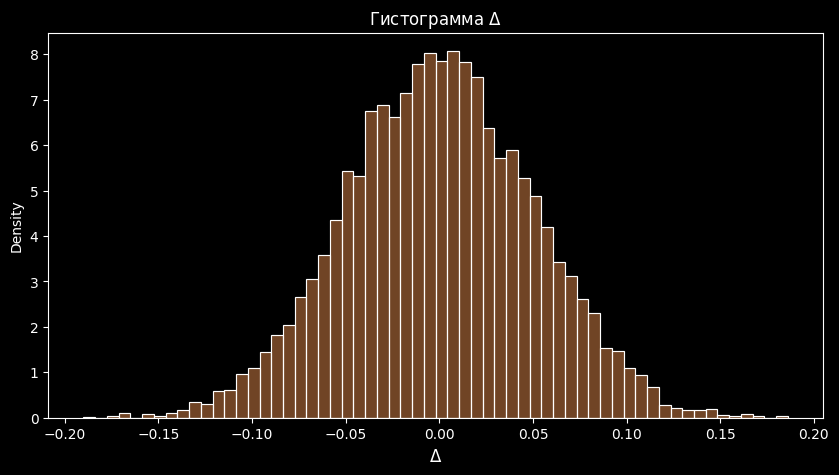

In [28]:
gen_sample_func = lambda N: example_dist.rvs(N)           # возвращает выборку из истинного распределения
theta_func = lambda sample: numpy.percentile(sample, 75)  # возвращает оценку Theta_estim по выборке

theta_estim_array = get_estim_theta_sample(len(example_sample), gen_sample_func, theta_func, B=10000) # генерим 10 тыс. Theta_estim
delta = theta_estim_array - theta # получаем 10 тыс. значений Delta

# Рисуем распределения Delta
pyplot.figure(figsize=(10, 5))
pyplot.title('Гистограмма $\Delta$', fontsize=12)
seaborn.histplot(delta, stat='density', alpha=0.5)
pyplot.xlabel('$\Delta$', fontsize=12)
pyplot.show()

2. Следующим шагом рассмотрим $\alpha/2, 1 - \alpha/2$ квантили этого распределения: $\Delta_{[\alpha/2]}, \Delta_{[1 - \alpha/2]}$. Тогда по определению квантилей $P(\Delta_{[\alpha/2]} < \widehat{\theta} - \theta < \Delta_{[1 - \alpha/2]}) = 1 - \alpha$.
    - В случае, когда у нас есть выборка размера B, мы можем взять оценки квантилей. Поэтому чем больше B, тем точнее получится оценка.
3. $P(\widehat{\theta} - \Delta_{[1 - \alpha/2]} < \theta < \widehat{\theta} - \Delta_{[\alpha/2]}) = 1 - \alpha$.
    - Таким образом, по определению доверительного интервала, $CI = (\widehat{\theta} - \Delta_{[1 - \alpha/2]}, \widehat{\theta} - \Delta_{[\alpha/2]})$

In [29]:
alpha = 0.05
left_delta, right_delta = numpy.quantile(delta, [alpha/2, 1-alpha/2])

left_bound, right_bound = theta_estim - right_delta, theta_estim - left_delta
print(f"Истинное theta: {round(theta, 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")

Истинное theta: 8.08
Полученный CI: (8.01, 8.2)


Мы видим, что истинное theta попало в дов. интервал.

Мы построили дов. интервал с учетом знания $\theta$ и истинного распределения выборки, но в реальности мы их не знаем. И тут приходит на помощь еще 1 хак.

---

### Идея 2: Эмпирическое распределение вместо истинного

Чтобы построить дов. интервал, мы должны как-то получить $\Delta_{[\alpha/2]}, \Delta_{[1 - \alpha/2]}$.

Вспомним, как определяется $\Delta:\ \Delta = \widehat{\theta} - \theta$. Для того, чтобы ее посчитать, мы использовали истинное значение $\theta$ и истинное распределение для генерации $\widehat{\theta}$.

**Но что если вместо истинного $\theta$ и истинного распределения использовать их приближения?**

Что здесь предлагается:

- У нас есть истинное распределение `dist` и истинная характеристика $\theta$ этого распределения.
- Но мы их не знаем. Так давайте заменим истинное распределение на эмпирическое распределение. И тэту возьмем как характеристику этого эмпирического распределения.

#### Вспомним, что такое эмпирическое распределение, и чем оно хорошо.

С эмпирическим распределением мы встречались, когда строили критерии согласия и однородности Колмогорова-Смирнова. Как оно строится?

0. Пусть $X_1, ..., X_n$ выборка из изначального распределения.
1. Функция распределения эмпирического распределения равна

$$\widehat{F_n}(x) = \frac{1}{n}\sum_i[X_i \leqslant x]$$

2. Теперь несложно показать, что чтобы построить выборку из эмпирического распределения, мы должны насемплировать **с возвращением** из изначальной выборки новую выборку нужного нам размера.
    - С возвращением означет, что каждый новый элемент равновероятно выбирается из всех элементов выборки, а не только из тех, что не были использованы ранее. При этом, если какой-то элемет встречается в N раз чаще другого, то в насемплированной выборке он также будет в среднем встречаться в N раз чаще.

Рассмотрим на примере.

- `numpy.random.choice` &mdash; [функция](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), решающая на Python эту задачу.

In [30]:
X = [2, 3, 4, 2]

# Насемплируем выборку размера 10 из эмпирического распределения, полученного по выборке X
emp_dist_X_gen = numpy.random.choice(X, replace=True, size=10)
emp_dist_X_gen

array([2, 2, 3, 2, 2, 4, 2, 2, 4, 4])


Чем хорошо эмпирическое распределение?
- Тем, что у него все характеристики известны.
- И оно сходится к истинному распределению на бесконечности (о чем мы уже говорили ранее).


Но какая будет характеристика $\theta$ у эмпирического распределения? Она не равна изначальной $\theta$! А будет равна оценке $\widehat{\theta}$ у изначальной выборки.

А значит теперь мы можем посчитать $\Delta^*$, полученное из эмпирического распределения. Ведь для этого нам нужны были:
- `sample_size` (не изменилось)
- `gen_sample_func`. Вместо истинного распределения теперь мы подставляем функцию получения выборки с возвращением.
- `theta_func` (не изменилось)
- `B` (не изменилось)
- `theta` поменялось на `theta_estim`

Сравним код, который был, с новым кодом.

In [31]:
# Пояснения к каждой строке см. выше

# Было - стало
# gen_sample_func = lambda N: example_dist.rvs(N)
gen_sample_func = lambda N: numpy.random.choice(example_sample, replace=True, size=N) # интересно, а какое N брать? всегда равное размеру исходной выборки? - да, см. далее

# theta_func = lambda sample: numpy.percentile(sample, 75)
theta_func = lambda sample: numpy.percentile(sample, 75) # не изменилось

# theta_estim_array = get_estim_theta_sample(len(example_sample), gen_sample_func, theta_func, B=10000)
theta_estim_asterisk_array = get_estim_theta_sample(len(example_sample), gen_sample_func, theta_func, B=10000)

# delta = theta_estim_array - theta
delta_asterisk = theta_estim_asterisk_array - theta_estim

Как мы видим, изменилась только первая функция, которая генерит i-ю выборку

### Главное допущение bootstrap: $\Delta \approx \Delta^*$.
- А на бесконечности это верно, потому что эмпирическое распределение равно истинному распределению.

Давайте проверим это допущение на примере:

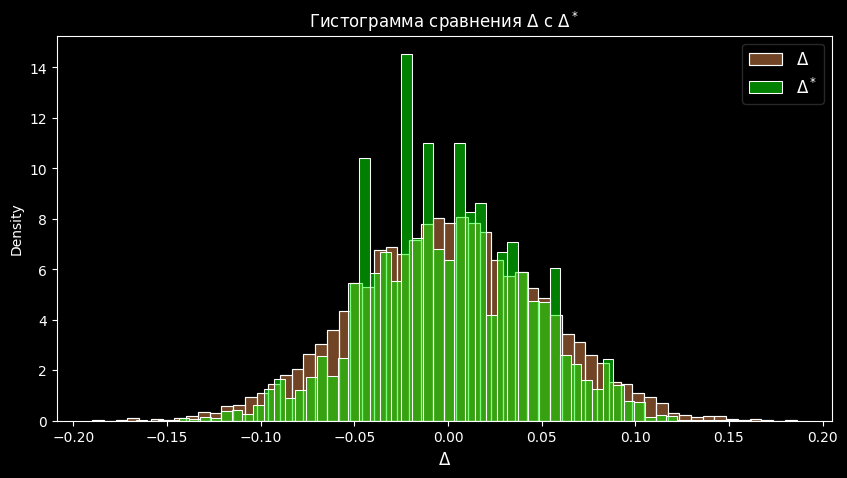

In [32]:
pyplot.figure(figsize=(10, 5))
pyplot.title('Гистограмма сравнения $\Delta$ с $\Delta^*$', fontsize=12)
seaborn.histplot(delta, stat='density', alpha=0.5, label='$\Delta$')
seaborn.histplot(delta_asterisk, stat='density', alpha=0.5, color='lime', label='$\Delta^*$')
pyplot.legend(fontsize=12)
pyplot.xlabel('$\Delta$', fontsize=12)
pyplot.show()

Мы видим, что распределения похожи, хоть и не идентичны. Видно, что $\Delta^*$ более шумная, но нетрудно убедиться, что процентили $\Delta^*$ и $\Delta$ будут очень похожими.  

Но исходя из нашего допущения мы можем заменить
- $CI = (\widehat{\theta} - \Delta_{[1 - \alpha/2]}, \widehat{\theta} - \Delta_{[\alpha/2]})$ на
- $CI = (\widehat{\theta} - \Delta^*_{[1 - \alpha/2]}, \widehat{\theta} - \Delta^*_{[\alpha/2]})$
  - Что такое $\Delta^*_i$? Это $ \theta^*_i - \widehat{\theta}$, где $\theta^*_i$ &mdash; оценка $\widehat{\theta}$, полученная по i-ой выборке, сгенерированной из эмпирического распределения!
  - Перепишем: $CI = (\widehat{\theta} - \theta^*_{[1 - \alpha/2]} + \widehat{\theta}, \widehat{\theta} - \theta^*_{[\alpha/2]} + \widehat{\theta})$


Итого: $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$. Так и строится полноценный бутстрап критерий!


**Главная проблема перехода к эмпирическому распределению:** ваше распределение не равно изначальному! Поэтому все характеристики этого распределения не равны характеристикам исходного распределения. И очень часто, забывая про это, вы можете начать использовать бутстрап неверно!

In [33]:
alpha = 0.05
left_theta_asterisk, right_theta_asterisk = numpy.quantile(theta_estim_asterisk_array, [alpha/2, 1-alpha/2])

left_bound, right_bound = 2 * theta_estim - right_theta_asterisk, 2 * theta_estim - left_theta_asterisk
print(f"Истинное theta: {round(theta, 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")

Истинное theta: 8.08
Полученный CI: (8.02, 8.19)


Давайте напишем теперь полноценный код бутстрап-критерия. Что мы сделали по шагам:

1. Считаем $\widehat{\theta}$ по изначальной выборке.
2. Написали генерацию выборок из эмпирического распределения: `lambda N: numpy.random.choice(example_sample, replace=True, size=N)`.
3. Написали функцию генерации $\theta^*$ (использовав логику Монте-Карло).
    - Выборки, которые будут сгенерированны внутри этого шага в цикле с помощью шага 1, называются **бутстрап**-выборками.
4. Считаем левый и правый квантили $\theta^*_{[\alpha/2]}, \theta^*_{[1 - \alpha/2]}$.
5. Считаем $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$.

Почему $2\widehat{\theta}$ - раскрыли формулу $\Delta:\ \Delta = \widehat{\theta} - \theta$

In [ ]:
def raw_bootstrap(sample, theta_func, alpha = 0.05):
    B = 10000

    theta_estim = theta_func(sample)
    gen_sample_func = lambda N: numpy.random.choice(sample, replace=True, size=N)

    theta_estim_asterisk_array = get_estim_theta_sample(len(example_sample), gen_sample_func, theta_func, B)
    left_theta_asterisk, right_theta_asterisk = numpy.quantile(theta_estim_asterisk_array, [alpha/2, 1-alpha/2])
    left_bound, right_bound = 2 * theta_estim - right_theta_asterisk, 2 * theta_estim - left_theta_asterisk

    return left_bound, right_bound

Проверим работоспособность:

In [ ]:
numpy.random.seed(42)
N = 20000
example_dist = stats.gamma(a=2, scale=3)
example_sample = example_dist.rvs(N)

theta_func = lambda sample: numpy.percentile(sample, 75)
raw_bootstrap(example_sample, theta_func, alpha = 0.05)

(8.020543156899208, 8.194299412190123)

Да, все отлично!



 ## Почему генерим бутстрап выборки именно такого же размера, как исходная?  
Чем больше выборка, которую мы сэмплируем, тем меньше портится некоторая характеристика (следует из З.Б.Ч). Следовательно, выборка, которую мы тут сэмплируем, должна быть такого же размера, как и изначальная, чтобы она качественно характеризовала то, насколько именно портится характеристика при сэмплировании.


## Более простой алгоритм бутстрапа

Давайте чуть упростим шаги:

1. Считаем $\widehat{\theta}$ по изначальной выборке.
2. В цикле размера `B`:
    1. Генерируем выборку с возвращением из изначальной выборки. Размер `N` &mdash; изначальный размер выборки. Эта выборка называется **бутстрап-выборкой**.
    2. Считаем по этой выборке $\theta^*_i$ точно так же, как считаем $\widehat{\theta}$ по изначальной выборке.
3. Сохраняем $\theta^*_1,\ ...,\ \theta^*_B$ в массив. Этот массив для нас как раз характеризует, как выглядит оценка $\theta$ после того, как мы $\widehat{\theta}$ ещё дополнительно испортили функцией шум ($\Delta$). Это распределение называется **бутстрап-распределением**. Т.е. по сути массив, который мы тут получили - это выборка из бутстрап-распределения
4. Строим доверительный интервал:
  1. Считаем левый и правый квантили $\theta^*_{[\alpha/2]}, \theta^*_{[1 - \alpha/2]}$.
  2. Считаем $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$.
  
(раскрыли формулу $\Delta:\ \Delta = \widehat{\theta} - \theta$)

In [35]:
def bootstrap_ci(sample, theta_func, alpha=0.05, B=2000):
    """
        Функция для построения доверительного интервала через бутстрап

        Параметры:
            - sample: изначальная выборка
            - theta_func: функция генерации оценки theta по выборке.
                - Например, lambda sample: numpy.percentile(sample, 75)
            - alpha: уровень значимости критерия. Доверительный интервал будет ширины 1-alpha.
        Возвращает:
            - левую и правую границы дов. интервала.
    """

    N = len(sample)
    theta_estim = theta_func(sample)

    theta_asterisk_array = []
    for _ in range(B):
        bootstrap_sample = numpy.random.choice(sample, replace=True, size=N)
        theta_asterisk = theta_func(bootstrap_sample)
        theta_asterisk_array.append(theta_asterisk)
    left_theta_asterisk, right_theta_asterisk = numpy.quantile(theta_asterisk_array, [alpha/2, 1-alpha/2])
    left_bound, right_bound = 2 * theta_estim - right_theta_asterisk, 2 * theta_estim - left_theta_asterisk

    return left_bound, right_bound

In [40]:
%%time
theta_func = lambda sample: numpy.percentile(sample, 75)
bootstrap_ci(sample, theta_func, alpha=0.05, B=10000)

CPU times: user 2.55 s, sys: 410 µs, total: 2.55 s
Wall time: 3.94 s


(np.float64(4.28420747502158), np.float64(4.791965069130439))

Вспомним, какаябыла точечная оценка:

In [37]:
numpy.percentile(sample, 75)

np.float64(4.533086595762159)

Код рабочий, но у него есть минус: он очень долгий. Поэтому, чтобы ускорить работу, давайте генерировать не 1, а сразу `batch_size` выборок, чтобы ускорить работу.

При этом, придется переписать функцию `theta_func`, чтобы она работала с массивом.

In [42]:
theta_func = lambda sample: numpy.percentile(sample, 75, axis=1)

def fast_bootstrap_ci(sample, theta_func, alpha=0.05, B=2000):
    """
        Функция для построения доверительного интервала через бутстрап

        Параметры:
            - sample: изначальная выборка
            - theta_func: функция генерации оценки theta по выборке.
                - Например, lambda sample: numpy.percentile(sample, 75)
            - alpha: уровень значимости критерия. Доверительный интервал будет ширины 1-alpha.
        Возвращает:
            - левую и правую границы дов. интервала.
    """
    batch_size = B // 20
    N = len(sample)
    # Добавляем размерность к выборке, чтобы работать с массивом массивов.
    theta_estim = theta_func(numpy.expand_dims(sample, axis=0)).ravel()
    assert len(theta_estim) == 1
    theta_estim = theta_estim[0]

    theta_asterisk_array = []
    for _ in range(0, B, batch_size):
        # Генерируем сразу batch_size выборок
        bootstrap_sample = numpy.random.choice(sample, replace=True, size=(batch_size, N))
        theta_asterisk = theta_func(bootstrap_sample).ravel()
        assert len(theta_asterisk) == batch_size
        theta_asterisk_array = numpy.concatenate([theta_asterisk_array, theta_asterisk])
    left_theta_asterisk, right_theta_asterisk = numpy.quantile(theta_asterisk_array, [alpha/2, 1-alpha/2])
    left_bound, right_bound = 2 * theta_estim - right_theta_asterisk, 2 * theta_estim - left_theta_asterisk

    return left_bound, right_bound

In [43]:
%%time
theta_func = lambda sample: numpy.percentile(sample, 75, axis=1)
fast_bootstrap_ci(sample, theta_func, alpha=0.05, B=10000)

CPU times: user 281 ms, sys: 11.6 ms, total: 293 ms
Wall time: 293 ms


(np.float64(4.285511204383765), np.float64(4.79740590749169))

Результат не изменился, но время работы сократилось в 6 раз!

А теперь самое время проверить наш бутстрап критерий! И снова с помощью Монте-Карло.

In [44]:
numpy.random.seed(42)

bad_cnt = 0
MC_size = 1000
N = 5000
alpha=0.05
theta = example_dist.ppf(0.75) # истинное значение
theta_func = lambda sample: numpy.percentile(sample, 75, axis=1)


for i in tqdm(range(MC_size)):
    # Генерирую выборку теста и контроля
    ex_sample = example_dist.rvs(N)

    left, right = fast_bootstrap_ci(ex_sample, theta_func, alpha=0.05) # получаем доверительный интервал

    bad_cnt += 1 - (left < theta < right) # проверяем, что истинное значение лежит в доверительном интервале


print(f"FPR: {round(bad_cnt / MC_size, 4)}")
print(f"CI={proportion_confint(count = bad_cnt, nobs = MC_size, alpha=0.05, method='wilson')}")

  0%|          | 0/1000 [00:00<?, ?it/s]

FPR: 0.056
CI=(0.043374813385441996, 0.07202334814973096)


Видим, что критерий работает валидно (хоть и очень долго), поэтому теперь самое время решить изначальную задачу!

In [ ]:
sample = numpy.load('bootstrap_example_1.npy')
fast_bootstrap_ci(sample, theta_func, alpha=0.05)

(4.392414326845837, 4.864705982389839)

Да, отлично! Мы смогли посчитать доверительный интервал.

### Промежуточные итоги про бутстрап

Бутстрап &mdash; способ построения доверительного интервала для любой характеристики распределения, состоящий из 2 эвристик:
- Замены истинного распределения на эмпирическое
- Генерация итоговой выборки $\theta^*$ с помощью Монте-Карло, чтобы корректно оценить квантили распределения.

Это универсальный способ посчитать доверительный интервал для любых нетривиальных характеристик и любых распределений. И часто может пригодиться в работе, поэтому вы обязательно должны помнить про него.

----

## Основные вопросы про бутстрап:

1. Когда бутстрап работает?
    - Когда выборки достаточно большие. Обе эвристики, из которых состоит бустрап, работают если:
        - $N$ достаточно большое. Тогда эмпирическое распределение лучше приближается к истинному и мы точнее оцениваем $\Delta^*$.
        - $B$ достаточно большое. Так мы точнее построим квантили распределения $\Delta^*$.
        - Первым параметром мы не всегда можем управлять, а вторым всегда.
2. Можно ли генерировать бутстрап-выборки другого размера, нежели $N$?
    - Нет, нельзя. Это следует из шага Монте-Карло, где мы пытаемся оценить $\widehat{\theta} - \theta$, а $\widehat{\theta}$ построена по выборке размера N.
3. Какого размера строит брать `B`?
    - Рекомендация: `B = 10000`.
    - Можно ли брать меньшего размера? Да, но надо проверять корректность с помощью Монте-Карло. Например, как мы сделали в примере выше.


  
### Двуxвыборочный бутстрап

Как с помощью бутстрапа построить доверительный интервал для разницы характеристик 2 распределений? Например, для разницы медиан в тесте и в контроле? Для этого надо повторить все те же шаги, что и для одновыборочного бутстрапа, но с модификацией: генерировать не 1, а 2 выборки сразу.

Пусть у вас есть выборка $X,\ Y$ размера $N, M$ соотвественно. Тогда:

1. Считаем $\widehat{\theta_X}, \widehat{\theta_Y}$ по изначальной выборке. Считаем разницу между ними $\widehat{\theta} = \widehat{\theta_X} - \widehat{\theta_Y}$.
2. В цикле размера `B`:
  1. Генерируем из выборок `X` и `Y` новые выборки с возвращением размера `N` и `M` соответственно.
  2. Считаем по этим выборкам $\theta^*_{X, i},\ \theta^*_{Y, i}$. $\theta^*_{i} = \theta^*_{X, i} - \theta^*_{Y, i}$
3. Сохраняем $\theta^*_1,\ ...,\ \theta^*_B$ в массив.
4. Строим доверительный интервал по формуле выше.

Profit!
    
    
-----



## Виды доверительных интервалов в бутстрапе

У бутстрапа есть 3 вида доверительных интервалов.

1. Центральный: $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$. Его мы уже рассмотрели.
2. Нормальный: $CI = (\widehat{\theta} \pm z_{1-\alpha/2}\cdot \sqrt{S^2_{\theta^*}})$
    - Если статистика $\widehat{\theta}$ распределена нормально (что на практике практически всегда так), то мы можем посчитать по выборке $\theta^*$ стандартное отклонение $\sqrt{S^2_{\theta^*}}$. мы делаем предположение, что $\sqrt{S^2_{\theta^*}} \approx \sqrt{S^2_{\widehat{\theta}}}$ . Тогда центр распределения $\theta$ будет лежать в данном дов. интервале.
    
3. Процентильный: $CI = (\theta^*_{[\alpha/2]}, \theta^*_{[1 - \alpha/2]})$
    - Теоретически он работает, если существует некоторая монотонная функция $F$, такая, что $\hat U = F(\hat\theta(X_i))$ и $\hat U \sim \mathcal{N}(\varphi, c^2)$, где $\varphi = F(\theta)$. Где $X$ &mdash; выборка, $ U$ &mdash; одно наблюдение случайной величины $\hat U$.
    - Док-во:
        - Пусть $U^\ast_i = F(\theta^*_i)$, а $u^*_{[\beta]}$ &mdash; оценка $\beta$-квантили распределения $U^*$. Тогда по свойству монотонности $F: u^*_{[\beta]} = F(\theta^*_{[\beta]})$.
        - Оценки для квантилей случайной величины $\hat U$ (помним, что $U$ &mdash; одно ее наблюдение) равны:
            - $\widehat{u_{[\alpha/2]}} = U - z_{1 - \alpha/2}c$
            - $\widehat{u_{[1-\alpha/2]}} = U + z_{1 - \alpha/2}c$.
        - Предположение бутстрапа: $u^*_{[\beta]} \approx \widehat{u_{[\beta]}}$.
        - $$\begin{align}
            P(\theta^*_{[\alpha/2]} < \theta < \theta^*_{[1 - \alpha/2]}) &=  P(F(\theta^*_{[\alpha/2]}) < F(\theta) < F(\theta^*_{[1 - \alpha/2]})) \\
            &= P(u^*_{[\alpha/2]} < \varphi < u^*_{[1 - \alpha/2]})) \\
            &\approx P(\widehat{u_{\alpha/2}} < \phi < \widehat{u_{1 - \alpha/2}} )) \\
            &= P(U - cz_{1 - \alpha/2} < \varphi < U + cz_{1 - \alpha/2})) \\
            &= P(- z_{1 - \alpha/2} < \dfrac{U - \varphi}{c} < z_{1 - \alpha/2}) \\
            &= 1 - \alpha
        \end{align}
        $$
     - **На практике интервал работает практически всегда.**
    
### Сравнение интервалов

Посмотрим на практике, насколько похожие значения они дают.

In [ ]:
def fast_bootstrap_ci(sample, theta_func, alpha=0.05):

    B = 1000 # Чтобы ускорить работу
    batch_size = B // 20
    N = len(sample)

    # Добавляем размерность к выборке, чтобы работать с массивом массивов.
    theta_estim = theta_func(numpy.expand_dims(sample, axis=0)).ravel()
    assert len(theta_estim) == 1
    theta_estim = theta_estim[0]

    theta_asterisk_array = []
    for _ in range(0, B, batch_size):
        # Генерируем сразу batch_size выборок
        bootstrap_sample = numpy.random.choice(sample, replace=True, size=(batch_size, N))
        theta_asterisk = theta_func(bootstrap_sample).ravel()
        assert len(theta_asterisk) == batch_size
        theta_asterisk_array = numpy.concatenate([theta_asterisk_array, theta_asterisk])
    left_theta_asterisk, right_theta_asterisk = numpy.quantile(theta_asterisk_array, [alpha/2, 1-alpha/2])
    std = numpy.std(theta_asterisk_array)


    central_left_bound, central_right_bound = 2 * theta_estim - right_theta_asterisk, 2 * theta_estim - left_theta_asterisk
    percentile_left_bound, percentile_right_bound = left_theta_asterisk, right_theta_asterisk
    norm_left_bound, norm_right_bound = theta_estim - norm().ppf(1-alpha/2) * std, theta_estim + norm().ppf(1-alpha/2) * std

    return {
        'central bootstrap': (central_left_bound, central_right_bound),
        'percentile bootstrap': (percentile_left_bound, percentile_right_bound),
        'norm bootstrap': (norm_left_bound, norm_right_bound)
    }

Проверим, насколько корректны дов. интервалы через Монте-Карло. FPR будет отражать, в скольких процентах случаев истинное $\theta$ не попал в доверительный интервал.

In [45]:
def mc_result_dict_creator(bad_cnt, MC_size):
    # Создает словарь, в котором значения по умолчанию инициализируются словарем
    mc_result = defaultdict(dict)
    for method in bad_cnt:
        fpr = bad_cnt[method] / MC_size
        left_fpr, right_fpr = proportion_confint(count = bad_cnt[method], nobs = MC_size, alpha=0.05, method='wilson')
        mc_result[method]['FPR'] = fpr
        mc_result[method]['FPR, left_bound'] = left_fpr
        mc_result[method]['FPR, right_bound'] = right_fpr
    return mc_result

def mc_bootstrap_checker(N, example_dist, theta, theta_func, alpha=0.05, MC_size = 1000):
    numpy.random.seed(42)

    # Создает словарь, в котором значения по умолчанию инициализируются 0
    bad_cnt = defaultdict(lambda: 0)
    for i in range(MC_size):
        ex_sample = example_dist.rvs(N)

        curr_res = fast_bootstrap_ci(ex_sample, theta_func, alpha=alpha)

        for ci_type in curr_res:
            left, right = curr_res[ci_type]
            bad_cnt[ci_type] += 1 - (left < theta < right)

    return mc_result_dict_creator(bad_cnt, MC_size)


In [ ]:
N_to_check = [50, 100, 500, 1000, 2000, 5000]

example_dist = stats.expon(scale=5)
theta = example_dist.ppf(0.5)
theta_func = lambda sample: numpy.percentile(sample, 50, axis=1)

final_results = {}
for N in tqdm(N_to_check):
    final_results[N] = mc_bootstrap_checker(N, example_dist, theta, theta_func, alpha=0.05, MC_size = 1000)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def show_FPR(result_dict, methods, colors):
    pyplot.figure(figsize=(18.5, 8))
    pyplot.title('Зависимость FPR от размера выборки для разных методов', fontsize=15)
    N_array = list(result_dict.keys())
    x_ticks = numpy.arange(0, len(N_array))

    pyplot.hlines(0.05, x_ticks[0], x_ticks[-1],
                   color='red', linestyle='-', label="$\\alpha$")
    for method, color in zip(methods, colors):
        FPR = []
        left_bound = []
        right_bound = []
        for N in result_dict:
            curr_dict = result_dict[N][method]
            FPR.append(curr_dict['FPR'])
            left_bound.append(curr_dict['FPR, left_bound'])
            right_bound.append(curr_dict['FPR, right_bound'])

        pyplot.plot(x_ticks, FPR, color=color, label=method)
        pyplot.fill_between(x_ticks, left_bound, right_bound,
                   color=color, alpha=0.2)

    pyplot.legend(fontsize=15)
    pyplot.xticks(x_ticks, N_array)
    pyplot.xlabel('N', fontsize=15)
    pyplot.ylabel('FPR', fontsize=15)
    pyplot.grid(linewidth=0.2)

    pyplot.show()

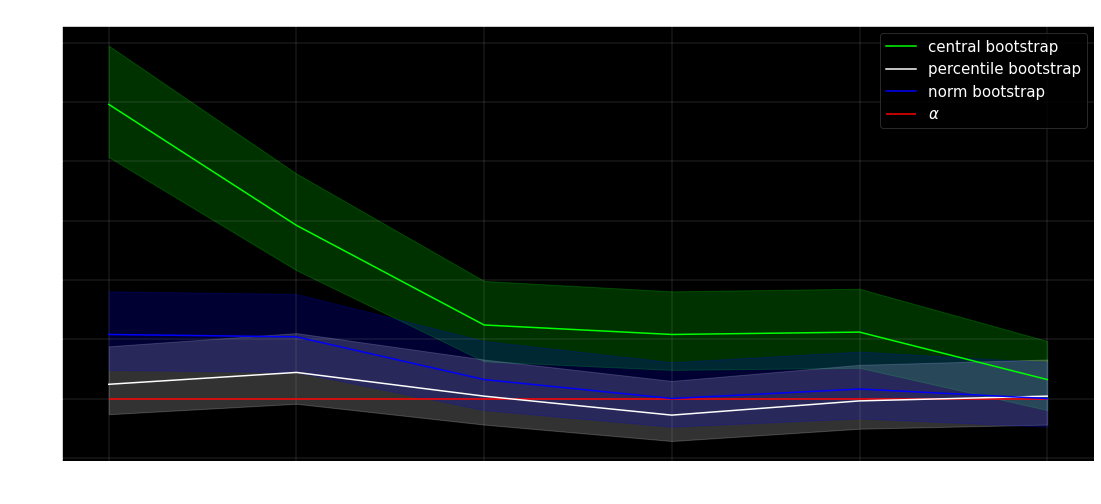

In [ ]:
colors = ['lime', 'white', 'blue']
methods = ['central bootstrap', 'percentile bootstrap', 'norm bootstrap']
show_FPR(final_results, methods, colors)

Мы получили несколько интересных выводов:
1) На 5000 все доверительные интервалы получились корректными: FPR везде равен 5% с учетом шума.
2) Удивительно, но центральный интервал сходится намного дольше, чем оставшиеся 2 вида интервалов. Поэтому, несмотря на то, что доказательная база у процентильного бутстрапа хуже, рекомендуют использовать именно его.
    
----

Давайте также посмотрим, насколько похожи доверительные интервалы на больших выборках:

In [ ]:
theta_func = lambda sample: numpy.percentile(sample, 50, axis=1)
ex_sample = example_dist.rvs(5000)
result = fast_bootstrap_ci(ex_sample, theta_func, alpha=0.05)

for ci_type in result:
    left, right = result[ci_type]
    print(f"{ci_type} interval: ({round(left, 2)}. {round(right, 2)})")

central bootstrap interval: (3.32. 3.54)
percentile bootstrap interval: (3.34. 3.56)
norm bootstrap interval: (3.32. 3.56)


Мы видим, что все они очень похожи и сильно не отличаются. А если взять больше выборку?

In [ ]:
ex_sample = example_dist.rvs(50000)
result = fast_bootstrap_ci(ex_sample, theta_func, alpha=0.05)

for ci_type in result:
    left, right = result[ci_type]
    print(f"{ci_type} interval: ({round(left, 2)}. {round(right, 2)})")

central bootstrap interval: (3.39. 3.48)
percentile bootstrap interval: (3.4. 3.49)
norm bootstrap interval: (3.4. 3.48)


Значения практически совпали! Отсюда можно также сделать вывод, что мощность всех 3 доверительных интервалов одинакова на больших выборках.

## T-test vs. Bootstrap

Мы уже поняли, что с помощью бутстрапа мы можем оценивать любые характеристики распределения, в частности средние. Мы также знаем, что для построения доверительного интервала для мат. ожидания существует t-test. В данном параграфе давайте посмотрим, есть ли какие-то преимущества у бутстрапа относительно t-test?

Мы ответим на 3 вопроса:
- может ли помочь bootstrap, когда не работает t-test?
- мощнее ли bootstrap, чем t-test?
- насколько быстрее один критерий, чем другой?

Давайте проведем тот же эксперимент, который мы провели ранее, сравнивая дов. интервалы, но со средним.

In [ ]:
def mc_ttest_checker(N, example_dist, theta, alpha=0.05, MC_size = 1000):
    numpy.random.seed(42)

    bad_cnt = defaultdict(lambda: 0)
    for i in range(MC_size):
        ex_sample = example_dist.rvs(N)

        ttest_pval = ttest_1samp(ex_sample, popmean=theta).pvalue
        bad_cnt['ttest'] += (ttest_pval < alpha)

    return mc_result_dict_creator(bad_cnt, MC_size)


In [ ]:
N_to_check = [5, 10, 20, 50, 100, 200, 500, 1000]

example_dist = stats.expon(scale=5)
theta = example_dist.mean()
theta_func = lambda sample: numpy.mean(sample, axis=1)

boot_results = {}
ttest_results = {}
final_results = {}
for N in tqdm(N_to_check):
    boot_results = mc_bootstrap_checker(N, example_dist, theta, theta_func, alpha=0.05, MC_size = 1000)
    ttest_results = mc_ttest_checker(N, example_dist, theta, alpha=0.05, MC_size = 1000)
    final_results[N] = dict(boot_results, **ttest_results)

  0%|          | 0/8 [00:00<?, ?it/s]

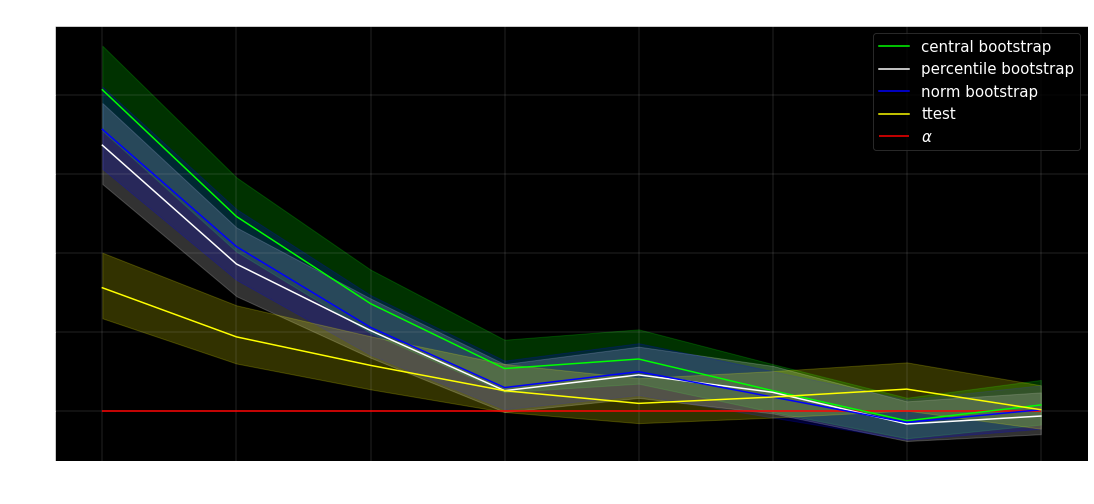

In [ ]:
colors = ['lime', 'white', 'blue', 'yellow']
methods = ['central bootstrap', 'percentile bootstrap', 'norm bootstrap', 'ttest']
show_FPR(final_results, methods, colors)

 Мы видим, что бутстрап начинает работать тогда же, когда и t-test, а до этого момента у него ошибка сильно больше!

Давайте посмотрим на ширину доверительного интервала у этих методов.

In [ ]:
N = 20
example_dist = stats.expon(scale=5)
ex_sample = example_dist.rvs(N)
theta = example_dist.mean()
theta_func = lambda sample: numpy.mean(sample, axis=1)

result = fast_bootstrap_ci(ex_sample, theta_func, alpha=0.05)
result['ttest'] = t.interval(alpha=0.95, loc=numpy.mean(ex_sample), df=len(ex_sample)-1, scale=stats.sem(ex_sample, ddof=1))


for method in result:
    left, right = result[method]
    print(f"{method} interval: ({round(left, 2)}. {round(right, 2)}), length={round(right - left, 2)}")

central bootstrap interval: (1.51. 4.68), length=3.17
percentile bootstrap interval: (1.77. 4.94), length=3.17
norm bootstrap interval: (1.6. 4.85), length=3.25
ttest interval: (1.42. 5.03), length=3.61


Мы видим, что бутстрап сильно заужает ширину дов. интервала. Поэтому мы и получаем большой FPR у бутстрапа при малых выборках.

Это значит, что
 - Бутстрап не работает в тех случаях, когда не работает t-test. И FPR у него сильно больше.
 - Тогда же, когда начинает работать t-test, начинает работать бутстрап.

То есть при оценке мат. ожидания выборки бутстрап не помогает в тех случаях, когда t-test не работает. Более того, он опасней в использовании в этих случаях.


Но может быть мощность у него будет больше?

Посмотрим на доверительные интервалы бутстрапа и t-test, когда мы знаем, что оба метода работают:

In [ ]:
N = 200
alpha = 0.05
ex_sample = example_dist.rvs(N)
result = fast_bootstrap_ci(ex_sample, theta_func, alpha=alpha)
result['ttest'] = t.interval(alpha=1 - alpha, loc=numpy.mean(ex_sample), df=len(ex_sample)-1, scale=stats.sem(ex_sample, ddof=1))


for method in result:
    left, right = result[method]
    print(f"{method} interval: ({round(left, 2)}. {round(right, 2)}), length={round(right - left, 2)}")

central bootstrap interval: (3.97. 5.37), length=1.39
percentile bootstrap interval: (4.11. 5.5), length=1.39
norm bootstrap interval: (4.04. 5.44), length=1.4
ttest interval: (4.04. 5.43), length=1.39


Мы видим, что интервалы у бутстрапа и t-test практически идентичны, и это при выборке размера 200. А если взять большую выборку?

In [ ]:
N = 10000
ex_sample = example_dist.rvs(N)
result = fast_bootstrap_ci(ex_sample, theta_func, alpha=alpha)
result['ttest'] = t.interval(alpha=1 - alpha, loc=numpy.mean(ex_sample), df=len(ex_sample)-1, scale=stats.sem(ex_sample, ddof=1))

for method in result:
    left, right = result[method]
    print(f"{method} interval: ({round(left, 2)}. {round(right, 2)}), length={round(right - left, 2)}")

central bootstrap interval: (4.91. 5.11), length=0.2
percentile bootstrap interval: (4.92. 5.12), length=0.2
norm bootstrap interval: (4.91. 5.11), length=0.2
ttest interval: (4.91. 5.11), length=0.2


Результаты практически идентичны. А это означает, что мощность бутстрап-критерия не будет отличаться от мощности t-test-критерия.

**Поэтому, если вы видите, что бутстрап дает доверительный интервал уже, чем t-test, то этим данным нельзя верить!** Очень вероятно, что у бутстрапа в этот момент FPR больше, чем заявлен!


И финальное: давайте сравним время работы 2 критериев:

In [ ]:
N = 100000
ex_sample = example_dist.rvs(N)

In [ ]:
%%time
_ = fast_bootstrap_ci(ex_sample, theta_func, alpha=alpha)

CPU times: user 1.26 s, sys: 604 ms, total: 1.87 s
Wall time: 1.87 s


In [ ]:
%%time
_ = t.interval(alpha=1 - alpha, loc=numpy.mean(ex_sample), df=len(ex_sample)-1, scale=stats.sem(ex_sample, ddof=1))


CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 1.23 ms


Мы видим, что на больших выборках разница по времени > 1000 раз!

Почему так происходит?
1. На одну бутстрап выборку тратится примерно O(N) времени. А на создание B выборок &mdash; `O(NB)` времени. Это и есть примерное время работы бутстрапа.
2.У T-test же этой проблемы нет: ему надо посчитать только среднее за O(N), посчитать стандартное отклонение за O(N) и константы квантилей за O(1) времени.

В итоге из-за этого бутстрап работает около `B` раз дольше времени, что мы и увидели на данных.


------

Поэтому, подводя итог сравнения t-test с bootstrap:
- bootstrap нельзя использовать, когда не работает t-test. Его FPR будет больше, чем у t-test.
- bootstrap не выигрывает по мощности у t-test. Они дают идентичные дов. интервалы, когда корректно работают.
- он работает в тысячи раз дольше, чем t-test.

----


# Итог: рекомендации к использованию бутстрапа

- Если вам нужно построить доверительный интервал для какой-то характеристики, то бутстрап ваш лучший друг. Он может помочь вам построить доверительный интервал для характеристики у одной выборки, так и оценить разностсть характеристик в AB-тесте, между тестом и контролем.
- При этом надо помнить, что на малых выборках его опасно использовать. Поэтому по возможности, проверяйте на Монте-Карло, можно ли использовать этот критерий в вашей задаче или нет.
- Также надо помнить, что бутстрап не пофиксит проблемы t-test: его опасно использовать тогда, когда t-test не работает. Вы ошибетесь с этим критерием сильнее.
- Ну и главное: этот криетрий очень долго работает. Поэтому, если вам надо реализовать критерий, который должен проанализировать гигантское число AB-тестов, то бутстрап вам не поможет.
